In [46]:
#cd drive/MyDrive/Live_workshops_treinamentos/

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")

# Download de recursos do NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer


#sns.set_style("white")
#set_palette(sns.color_palette("colorblind"))

In [ ]:
## CREATE PALETTE COLOR
color_pal = sns.color_palette("colorblind")

# PREPARANDO A BASE
- o arquivo original XLSM deu problemas na importação, fiz um script para corrigir algumas coisas para manter os dados com mais qualidade possível

In [ ]:
d = pd.read_excel("Planilha em First_Desafio_ciencia_de_dados_SR.xlsm",usecols='A')
print(d.shape)
d.head()

In [ ]:
import re
lista_final = []
lista_erro = []

for linha in d.iterrows():
  try:
    id_, texto = linha[0],linha[1].values[0]
    lista_temp = []

    split_ = re.split(""","|",""",texto)
    if len(split_) < 3:
      split_ = re.split(""",""",texto)

    name = split_[0]
    desc = split_[1]

    lista_temp.append(name)
    lista_temp.append(desc)
    lista_temp.extend(split_[2].split(','))

    if len(lista_temp) == 8:
      lista_final.append(lista_temp)
    else:
      lista_erro.append( (id_, "COLS NÃO BATEU", len(lista_temp)) )

  except Exception as e:
    #print(id_,e)
    lista_erro.append( (id_,e) )
  #break

#pd.DataFrame(lista_final)
len(lista_erro)

In [ ]:
pd.DataFrame(lista_final, columns = ['name','description','employees','total_funding','city','subcountry','lat','lng']).to_csv("teste_base_first.csv",index=False)

# IMPORTANDO BASE DE DADOS

In [6]:
#dados = pd.read_csv("Planilha em First_Desafio_ciencia_de_dados_SR.csv",sep=';')
dados = pd.read_csv("teste_base_first.csv")
print(dados.shape)
dados.head()

(16819, 8)


,name,description,employees,total_funding,city,subcountry,lat,lng
0,fitin,fitin is the latest fit tech platform that pro...,1.0,NaN,toronto,ontario,43.700109999999995,-79.4163
1,quinditech,our services include independent & collaborati...,10.0,NaN,montreal,quebec,45.50884,-73.58781
2,botfirst,chatlanding is a digital chatbot platform wher...,1.0,NaN,toronto,ontario,43.700109999999995,-79.4163
3,stylify,stylify is a mobile platform that connects peo...,1.0,NaN,toronto,ontario,43.700109999999995,-79.4163
4,weave travels,weave is a web platform for travel companies. ...,1.0,NaN,toronto,ontario,43.700109999999995,-79.4163


In [ ]:
dados.info()

In [ ]:
## APAGANDO LINHAS EM BRANCO EM DESCRIP
dados = dados.dropna(subset=['description'] )
dados.info()

# 1 – Pre-processamento dos textos|

In [8]:
# Função para pré-processar o texto
def preprocess_text(text):
    # Remover caracteres especiais e números
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # converter tudo para minusculo
    text = text.lower()

    # Tokenização
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização
    #lemmatizer = WordNetLemmatizer()
    #tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = ' '.join(tokens)

    return tokens

In [9]:
# Aplicar a função de pré-processamento na coluna 'description'
dados['description_clean'] = dados['description'].apply(lambda x: preprocess_text(str(x)))
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16819 entries, 0 to 16818
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               16818 non-null  object
 1   description        16819 non-null  object
 2   employees          16819 non-null  object
 3   total_funding      1756 non-null   object
 4   city               16812 non-null  object
 5   subcountry         16812 non-null  object
 6   lat                16812 non-null  object
 7   lng                16812 non-null  object
 8   description_clean  16819 non-null  object
dtypes: object(9)
memory usage: 1.2+ MB


In [10]:
## função para converter texto em número
# tem um tratamento de erro caso encontre algum registro que não seja número em texto
def convert_num(valor):
  try:
    return float(valor)
  except:
    return np.NaN

dados['total_funding'] = dados['total_funding'].apply(convert_num)
dados['employees'] = dados['employees'].apply(convert_num)
dados['lat'] = dados['lat'].apply(convert_num)
dados['lng'] = dados['lng'].apply(convert_num)

## TF-IDF
- vetorização dos textos utilizando TF-IDF

In [11]:
# Vectorizer para transformar o texto em vetores TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dados['description_clean'])

In [12]:
## CRIANDO DF COM a FREQUENCIAS DO TFIDF
df_count_dfidf = pd.DataFrame(zip(tfidf_matrix.toarray().sum(axis=0),
                            tfidf_vectorizer.get_feature_names_out()),columns = ['QTD','TOKEN'])

In [13]:
## CRIANDO DF COM TFIDF
df_dfidf = pd.DataFrame(tfidf_matrix.toarray(),
                        columns = tfidf_vectorizer.get_feature_names_out())
#df_dfidf.head()

## AGRUPAMENTO COM CLUSTER

In [ ]:
from sklearn.decomposition import PCA
# Init a PCA object where we will only keep the 2 first principal components
pca = PCA()

# Use the `fit_transform` method from this object to our dataframe
pca_results = pca.fit_transform(df_dfidf)


In [ ]:
plt.scatter(pca_results[:, 0], # position on the first principal component of the observations
            pca_results[:, 1], alpha=0.7) # position on the second principal component of the observations
plt.show()

In [ ]:
# Inicializar o modelo K-Means
k = 5  # Número de clusters (ajuste conforme necessário)
kmeans = KMeans(n_clusters=k)
kmeans.fit(tfidf_matrix)

# Adicionar as etiquetas de cluster ao dataframe
df_dfidf['cluster_label'] = kmeans.labels_
dados['cluster_label'] = kmeans.labels_


In [ ]:
dados['cluster_label'].value_counts()

In [ ]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
for c in dados['cluster_label'].unique():
  text = " ".join(i for i in dados.query(f"cluster_label == {c}").description_clean)
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  plt.figure( figsize=(7,7))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

## AGRUPAMENTO COM LDA

In [14]:
from sklearn.decomposition import LatentDirichletAllocation

# Inicializar o modelo LDA
num_topics = 5  # Número de tópicos (ajuste conforme necessário)
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [16]:
# Mostrar os termos mais importantes para cada tópico
def return_top_topics(model, feature_names, no_top_words):
  final_topic = []
  for topic_idx, topic in enumerate(model.components_):
      topic_list = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
      final_topic.append(topic_list)
  return final_topic

In [17]:
## criando coluna com o número do tópico de cada linha
topic_distribution   = lda.transform(tfidf_matrix)
dados['label_topic'] = topic_distribution.argmax(axis=1)
dados['label_topic'].value_counts()

1    13652
0     2011
4     1026
2       94
3       36
Name: label_topic, dtype: int64

In [38]:
from collections import Counter

frase_referencia = 'water quality water efficiency water contamination human consumption water resources'

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
palavras_chave_topicos = return_top_topics(lda, tfidf_feature_names, 10)

# Tokenizar a frase de referência
palavras_frase_referencia = frase_referencia.split()

# Contar a frequência das palavras na frase de referência
contagem_palavras_frase_referencia = set(palavras_frase_referencia)

for i, palavras_topico in enumerate(palavras_chave_topicos):
    # Calcular a sobreposição entre as palavras da frase e as palavras-chave do tópico
    sobreposição = len(set(palavras_topico) & contagem_palavras_frase_referencia)
    print(f"Sobreposição com Tópico {i}: {sobreposição} palavras em comum")

Sobreposição com Tópico 0: 0 palavras em comum
Sobreposição com Tópico 1: 0 palavras em comum
Sobreposição com Tópico 2: 0 palavras em comum
Sobreposição com Tópico 3: 0 palavras em comum
Sobreposição com Tópico 4: 1 palavras em comum


# 2 – Análise exploratória dos cluster

In [19]:
##filtrando apenas registros do topico 4
dados_selecionados = dados.query("label_topic == 4")
dados_selecionados.head()

,name,description,employees,total_funding,city,subcountry,lat,lng,description_clean,label_topic
407,kerr properties,kerr properties offers new condos and town hou...,10.0,NaN,langley,british columbia,49.106472,-122.550131,kerr properties offers new condos town houses ...,4
467,aitken robertson criminal lawyers,the ontario criminal lawyers at aitken roberts...,1000.0,NaN,toronto,ontario,43.700110,-79.416300,ontario criminal lawyers aitken robertson law ...,4
723,thejpl.co,the jungle premier league (jpl) is a football ...,1.0,NaN,toronto,ontario,43.700110,-79.416300,jungle premier league jpl football management ...,4
782,legit kicks,"established in 2017, legit kicks is a premier ...",1.0,NaN,spruce grove,alberta,53.533440,-113.918740,established legit kicks premier sneaker shop s...,4
1857,gurulink.ca for our client in montreal,"customer apparel, hats, caps and snapbacks wit...",10.0,NaN,montreal,quebec,45.508840,-73.587810,customer apparel hats caps snapbacks minimums ...,4


In [20]:
dados_selecionados.describe()

,employees,total_funding,lat,lng,label_topic
count,1026.000000,6.600000e+01,1026.000000,1026.000000,1026.0
mean,75.745614,5.467893e+07,47.528714,-105.012713,4.0
std,484.560656,1.429220e+08,2.963580,20.699156,0.0
min,0.000000,5.900000e+04,43.100120,-123.119340,4.0
25%,0.000000,2.048536e+06,43.700110,-123.119340,4.0
50%,0.000000,6.500000e+06,49.249660,-114.085290,4.0
75%,1.000000,3.000000e+07,49.249660,-79.416300,4.0
max,5000.000000,9.986668e+08,56.726760,-60.325760,4.0


## Quais insights você pode obter a partir desses dados? Quais são as principais cidades (pólos de desenvolvimento) para essa solução?

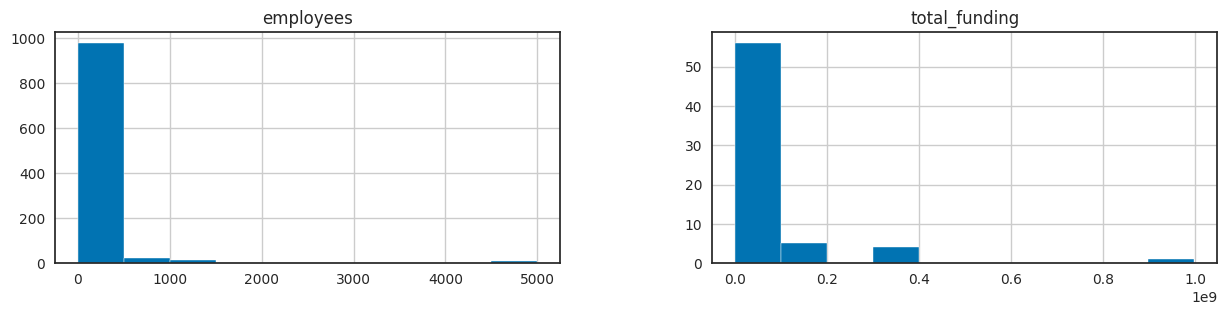

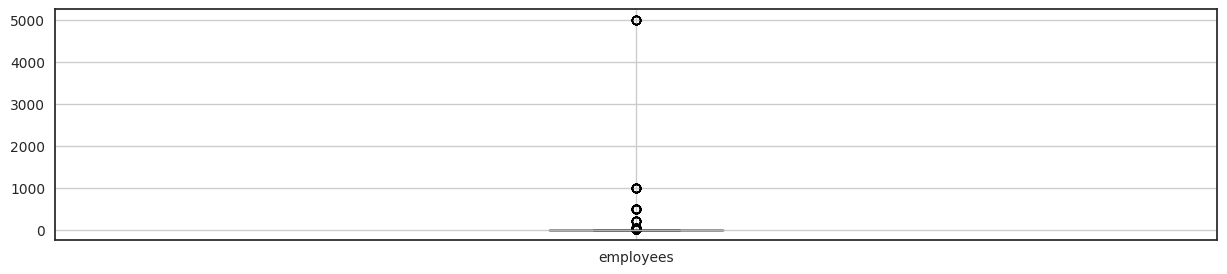

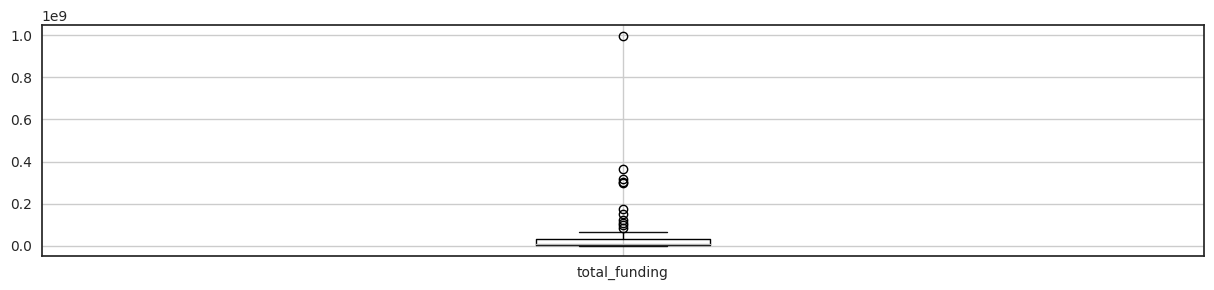

In [21]:
dados_selecionados[['employees','total_funding']].hist(figsize = (15,3))
plt.show()

dados_selecionados[['employees']].boxplot(figsize = (15,3))
plt.show()

dados_selecionados[['total_funding']].boxplot(figsize = (15,3))
plt.show()

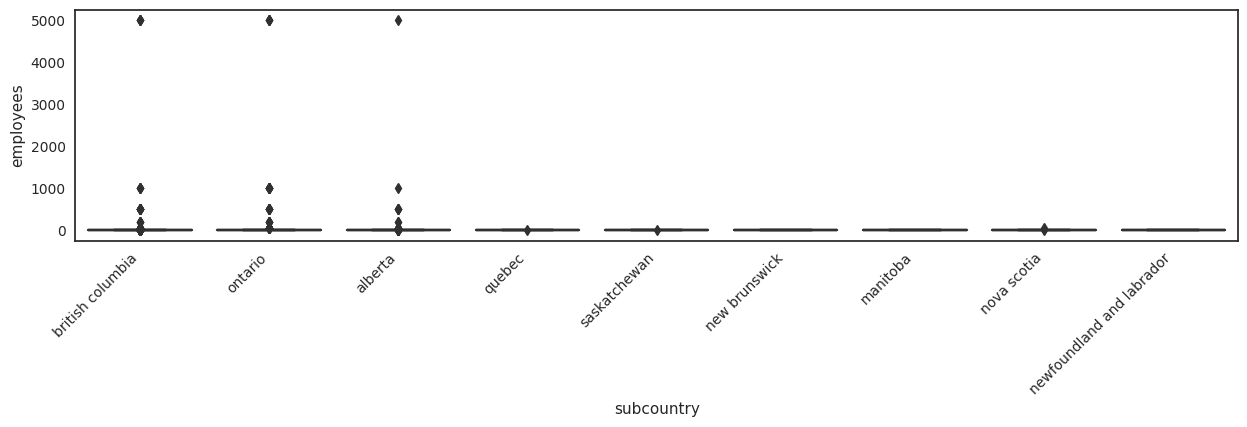

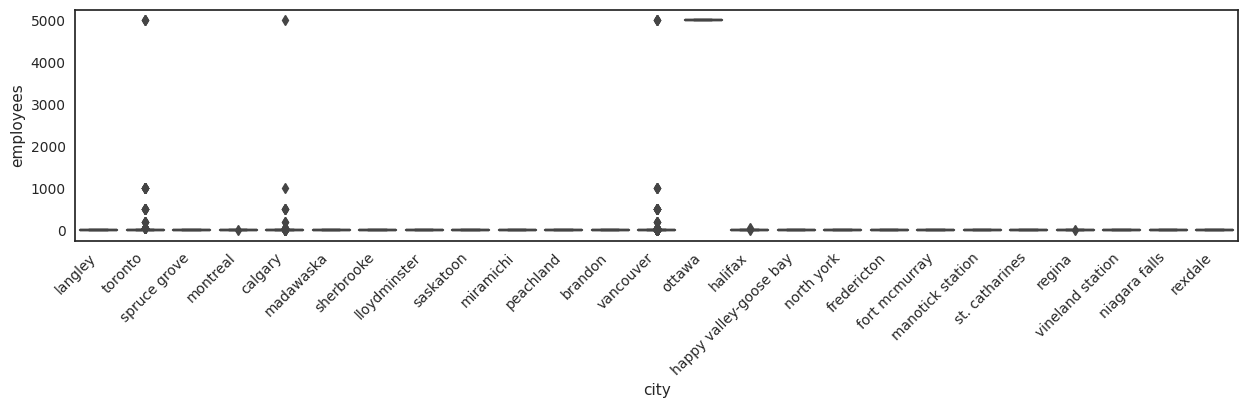

In [43]:
plt.figure(figsize = (15,3))
sns.boxplot(x = 'subcountry', y = 'employees', data = dados_selecionados,
            showfliers = True)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

plt.figure(figsize = (15,3))
sns.boxplot(x = 'city', y = 'employees', data = dados_selecionados,
            showfliers = True)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

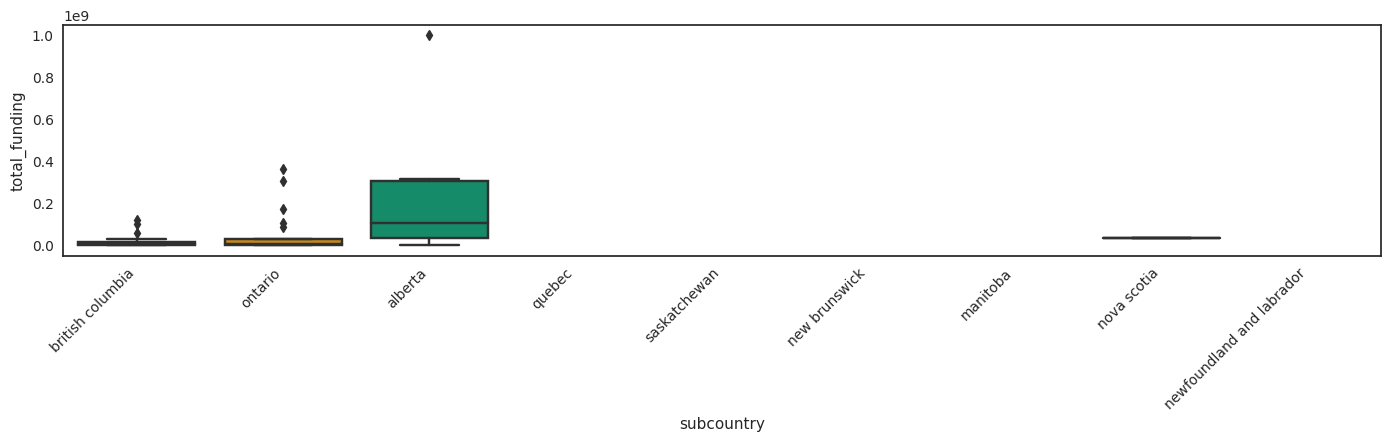

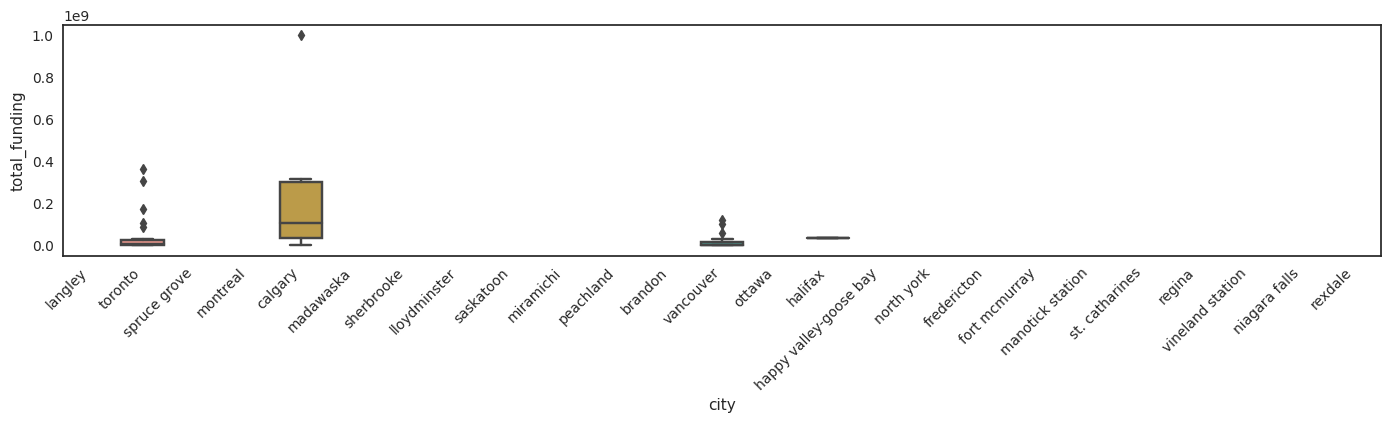

In [45]:
plt.figure(figsize = (17,3))
sns.boxplot(x = 'subcountry', y = 'total_funding', data = dados_selecionados,
            showfliers = True)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

plt.figure(figsize = (17,3))
sns.boxplot(x = 'city', y = 'total_funding', data = dados_selecionados,
            showfliers = True)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

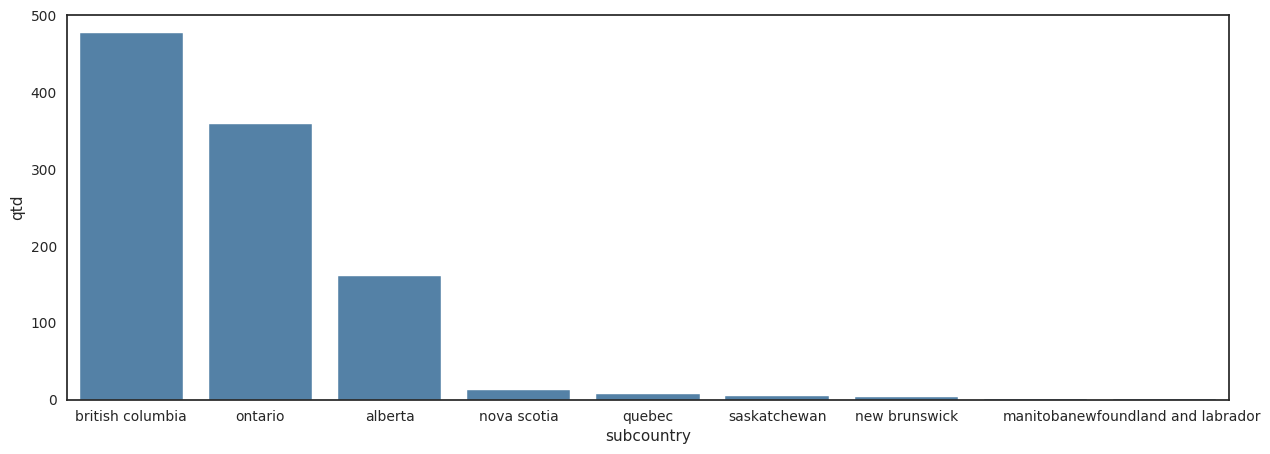

In [24]:
df_count = dados_selecionados.subcountry.value_counts().to_frame().reset_index().rename({'subcountry':'qtd','index':'subcountry'},axis=1)

plt.figure(figsize = (15,5))
sns.barplot(x = 'subcountry', y = 'qtd', data = df_count, color = 'steelblue')
plt.show()

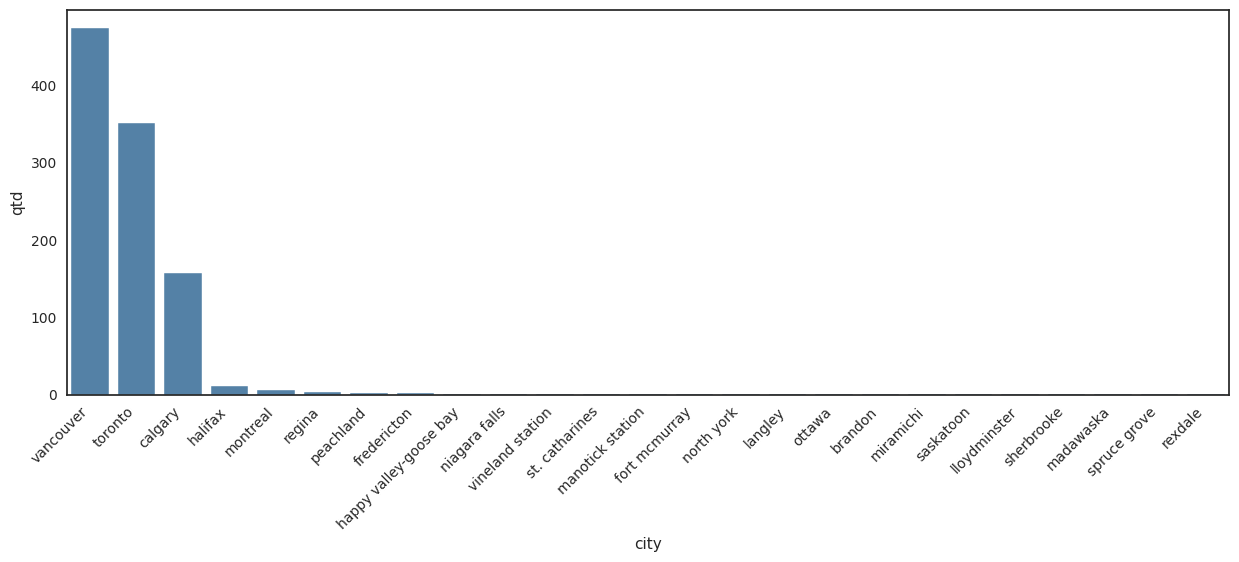

In [25]:
df_count = dados_selecionados.city.value_counts().to_frame().reset_index().rename({'city':'qtd','index':'city'},axis=1)

plt.figure(figsize = (15,5))
sns.barplot(x = 'city', y = 'qtd', data = df_count, color = 'steelblue')
plt.xticks(rotation = 45, ha = 'right')

plt.show()

In [39]:
df_count = dados_selecionados.groupby(['subcountry','city']).name.count().reset_index().rename({'name':'qtd'},axis=1)
df_count

,subcountry,city,qtd
0,alberta,calgary,158
1,alberta,fort mcmurray,1
2,alberta,lloydminster,1
3,alberta,spruce grove,1
4,british columbia,langley,1
5,british columbia,peachland,2
6,british columbia,vancouver,474
7,manitoba,brandon,1
8,new brunswick,fredericton,2
9,new brunswick,miramichi,1


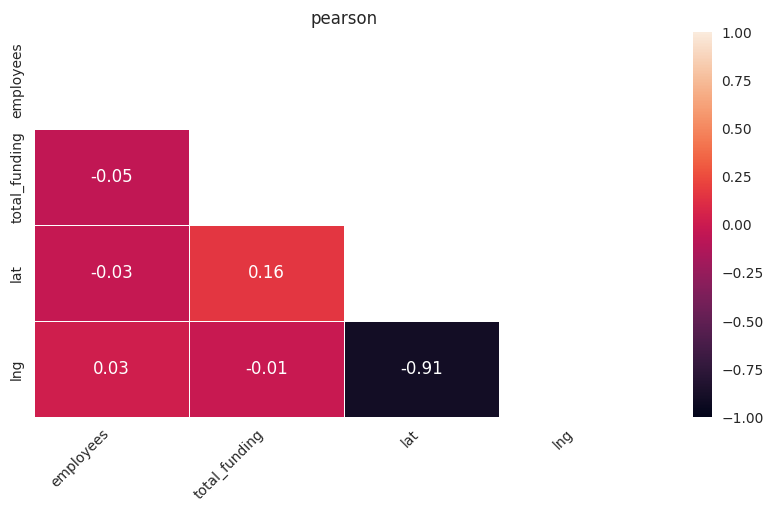

In [41]:
fig, axs = plt.subplots(1,1, figsize=(10, 5), sharey=False)
fig.subplots_adjust(hspace=.5, wspace=1.35)

dados_corr  = dados_selecionados.drop(columns = ['label_topic'])
corr        = dados_corr.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, annot=True, square=False,
            fmt=".2f",linewidths=.5,ax = axs)

axs.set_title("pearson")
axs.set_xticklabels(axs.get_xticklabels(), rotation = 45,ha="right")

plt.show()